# Introduction

Previously in a Kaggle Kernel, I discovered the Class Activate Map (CAM) using a VVG16. In this Notebook, I'll explore the CAM of Inception V3 in the prediction of few images (including the discovery from University of Tubingen regarding the imapct of the texture on the prediction (<a href="https://openreview.net/pdf?id=Bygh9j09KX">link</a>))

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import decode_predictions

import matplotlib.pyplot as plt

from scipy.stats import entropy
from numpy.linalg import norm

from PIL import Image
import cv2

# Dataset preparation

Very simple step here. Let's load some images, resize them to 299x299 and scale them in a range of [0, 1]

In [2]:
test_image1 = Image.open("boat1.jpg")
test_image2 = Image.open("boat2.jpg")
test_image3 = Image.open("boat3.jpg")
test_image4 = Image.open("cat.jpg")
test_image5 = Image.open("voiture.jpg")
test_image6 = Image.open("voiture2.jpg")

In [3]:
test_image1 = test_image1.resize((299, 299))
test_image2 = test_image2.resize((299, 299))
test_image3 = test_image3.resize((299, 299))
test_image4 = test_image4.resize((299, 299))
test_image5 = test_image5.resize((299, 299))
test_image6 = test_image6.resize((299, 299))

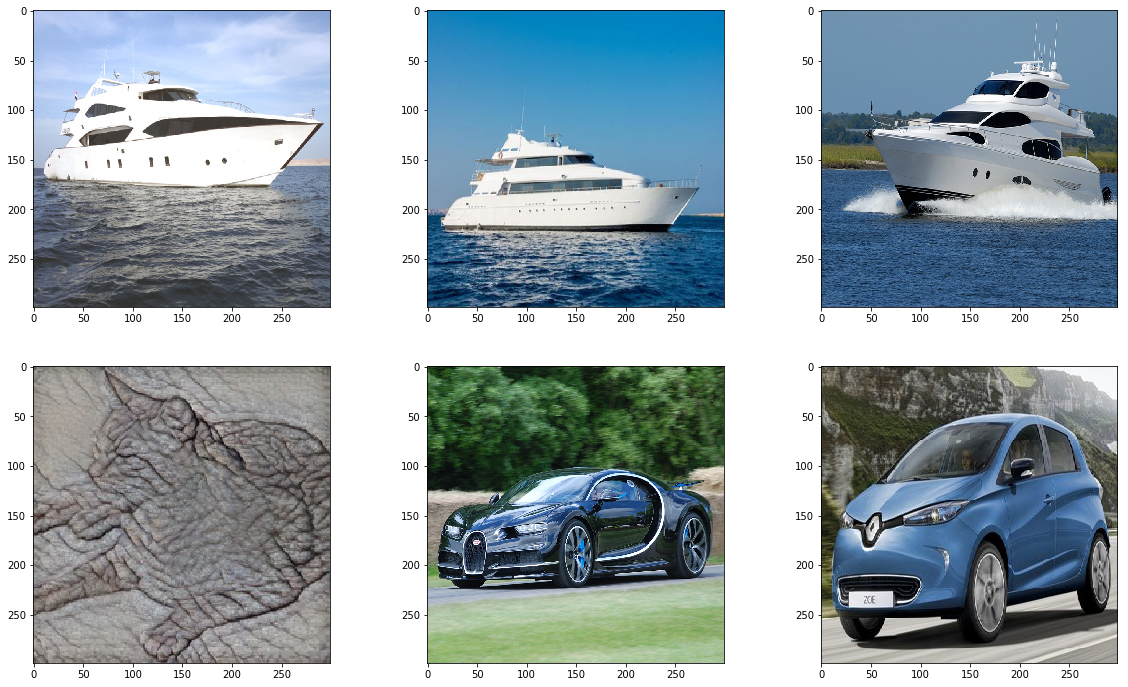

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
axes[0, 0].imshow(test_image1)
axes[0, 1].imshow(test_image2)
axes[0, 2].imshow(test_image3)
axes[1, 0].imshow(test_image4)
axes[1, 1].imshow(test_image5)
axes[1, 2].imshow(test_image6)
plt.show()

In [5]:
X = np.zeros(shape=(6, 299, 299, 3), dtype=np.float32)
X[0] = np.array(test_image1)
X[1] = np.array(test_image2)
X[2] = np.array(test_image3)
X[3] = np.array(test_image4)
X[4] = np.array(test_image5)
X[5] = np.array(test_image6)
X /= 255.0

# full prediction

We can now load the pre-trained model and make the classifications

In [6]:
IMG_SHAPE = (299, 299, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=True, 
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [8]:
y_hat = base_model.predict(X)

In [9]:
imagenet_labels = decode_predictions(y_hat, top=3)

In [10]:
print('Predicted:', imagenet_labels)

Predicted: [[('n04273569', 'speedboat', 0.23419371), ('n03673027', 'liner', 0.21059692), ('n02981792', 'catamaran', 0.16518675)], [('n03673027', 'liner', 0.9226364), ('n02981792', 'catamaran', 0.013785596), ('n09428293', 'seashore', 0.0009258849)], [('n04273569', 'speedboat', 0.78583926), ('n02704792', 'amphibian', 0.07139961), ('n02981792', 'catamaran', 0.06575323)], [('n02504458', 'African_elephant', 0.5244344), ('n02504013', 'Indian_elephant', 0.24280018), ('n01871265', 'tusker', 0.1114159)], [('n04285008', 'sports_car', 0.88917637), ('n03100240', 'convertible', 0.033024576), ('n02974003', 'car_wheel', 0.017411336)], [('n03770679', 'minivan', 0.5996617), ('n04285008', 'sports_car', 0.02500174), ('n02814533', 'beach_wagon', 0.020977488)]]


And here is the result. 
At first sight, it's surprising that the 1st image has only 23% of confidence compared to the 2 other boat images. We can also see that the twingo is considered as Minivan. This is basically due to rescale which modifies proportions too much. And finnaly, the cat is classified as Affrican Elephant with more than 50% confidence. 

Let's now look at the top-5 instead of top-1

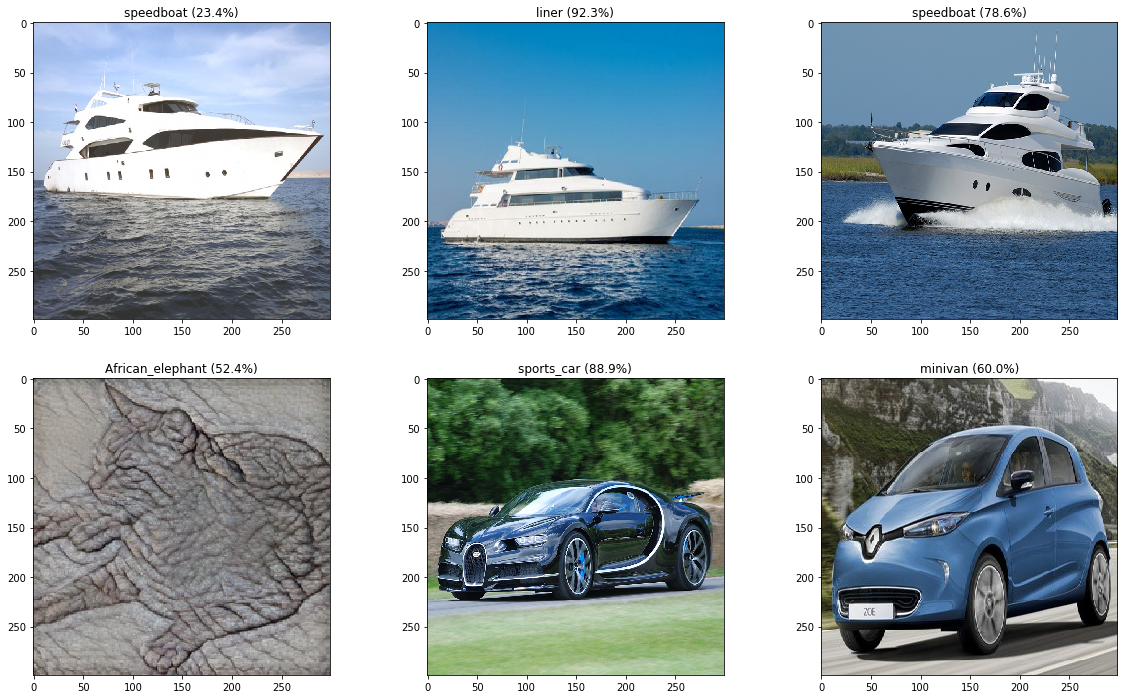

In [11]:
idx = np.argmax(y_hat, axis=1)   # imagenet label is at the end of the notebook
percent = 100*np.max(y_hat, axis=1)

fig, axes = plt.subplots(2, 3, figsize=(20,12))
axes[0, 0].imshow(test_image1)
axes[0, 0].set_title("{} ({:.1f}%)".format(imagenet_labels[0][0][1], 100*imagenet_labels[0][0][2]))
axes[0, 1].imshow(test_image2)
axes[0, 1].set_title("{} ({:.1f}%)".format(imagenet_labels[1][0][1], 100*imagenet_labels[1][0][2]))
axes[0, 2].imshow(test_image3)
axes[0, 2].set_title("{} ({:.1f}%)".format(imagenet_labels[2][0][1], 100*imagenet_labels[2][0][2]))
axes[1, 0].imshow(test_image4)
axes[1, 0].set_title("{} ({:.1f}%)".format(imagenet_labels[3][0][1], 100*imagenet_labels[3][0][2]))
axes[1, 1].imshow(test_image5)
axes[1, 1].set_title("{} ({:.1f}%)".format(imagenet_labels[4][0][1], 100*imagenet_labels[4][0][2]))
axes[1, 2].imshow(test_image6)
axes[1, 2].set_title("{} ({:.1f}%)".format(imagenet_labels[5][0][1], 100*imagenet_labels[5][0][2]))
plt.show()

In [12]:
res = decode_predictions(y_hat, top=5)
for i, row in enumerate(res):
    print("Image {}".format(i))
    for j, (_, label, percent) in enumerate(row):
        print("\tRank {} - {} ({:.1f}%)".format(j+1, label, 100*percent))

Image 0
	Rank 1 - speedboat (23.4%)
	Rank 2 - liner (21.1%)
	Rank 3 - catamaran (16.5%)
	Rank 4 - trimaran (2.6%)
	Rank 5 - dock (1.7%)
Image 1
	Rank 1 - liner (92.3%)
	Rank 2 - catamaran (1.4%)
	Rank 3 - seashore (0.1%)
	Rank 4 - dock (0.1%)
	Rank 5 - howler_monkey (0.1%)
Image 2
	Rank 1 - speedboat (78.6%)
	Rank 2 - amphibian (7.1%)
	Rank 3 - catamaran (6.6%)
	Rank 4 - trimaran (0.6%)
	Rank 5 - fireboat (0.4%)
Image 3
	Rank 1 - African_elephant (52.4%)
	Rank 2 - Indian_elephant (24.3%)
	Rank 3 - tusker (11.1%)
	Rank 4 - buckle (0.6%)
	Rank 5 - nail (0.6%)
Image 4
	Rank 1 - sports_car (88.9%)
	Rank 2 - convertible (3.3%)
	Rank 3 - car_wheel (1.7%)
	Rank 4 - grille (1.4%)
	Rank 5 - racer (0.3%)
Image 5
	Rank 1 - minivan (60.0%)
	Rank 2 - sports_car (2.5%)
	Rank 3 - beach_wagon (2.1%)
	Rank 4 - car_wheel (1.1%)
	Rank 5 - grille (0.8%)


For the first boat, we can see some hesitation between speedboat and liner. This is also something tricky for humans. However for the case of the cat, 88% of the cumulative confidence is about elephants... 12% is balanced over 997 other classes. Let's now look at the confidence of the model about the fact that the image is a cat.

In [13]:
imagenet_sublabels = {
    281: 'tabby, tabby cat',
    282: 'tiger cat',
    283: 'Persian cat',
    284: 'Siamese cat, Siamese',
    285: 'Egyptian cat',
    286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
    287: 'lynx, catamount',
    288: 'leopard, Panthera pardus',
    289: 'snow leopard, ounce, Panthera uncia',
    290: 'jaguar, panther, Panthera onca, Felis onca',
    291: 'lion, king of beasts, Panthera leo',
    292: 'tiger, Panthera tigris',
}

In [14]:
res2 = np.argsort(y_hat[3])[::-1]
ans = []
for i in range(281, 286):
    percent = 100*y_hat[3, i]
    label = imagenet_sublabels[i]
    ranking = np.argwhere(res2 == i)[0][0]
    ans.append((ranking, label, percent))

ans.sort(key=lambda x:x[0])

for ranking, label, percent in ans:
    print("\tRank {} - {} ({:.5f}%)".format(ranking, label, percent))

	Rank 48 - Persian cat (0.03445%)
	Rank 343 - Siamese cat, Siamese (0.00703%)
	Rank 681 - tabby, tabby cat (0.00332%)
	Rank 771 - tiger cat (0.00266%)
	Rank 981 - Egyptian cat (0.00082%)


The model see a cat for the first time is rank 48... with a confidence of 0.03% !! That confirms a CNN is really good at detecting patterns and not shapes

# Feature Extraction

Quickly, we cann look at the feature vector for each image

In [15]:
out = base_model.get_layer("avg_pool").output
inp = base_model.input

get_output = tf.keras.backend.function([inp], [out])

In [16]:
features = get_output(X)[0]

In [17]:
features.shape

(6, 2048)

The model outputs a 2048 feqture vector, to easy visibility, they will be reshaped to 64x32 pixel image and plot with the same scale

In [18]:
vmin, vmax = features.min(), features.max()

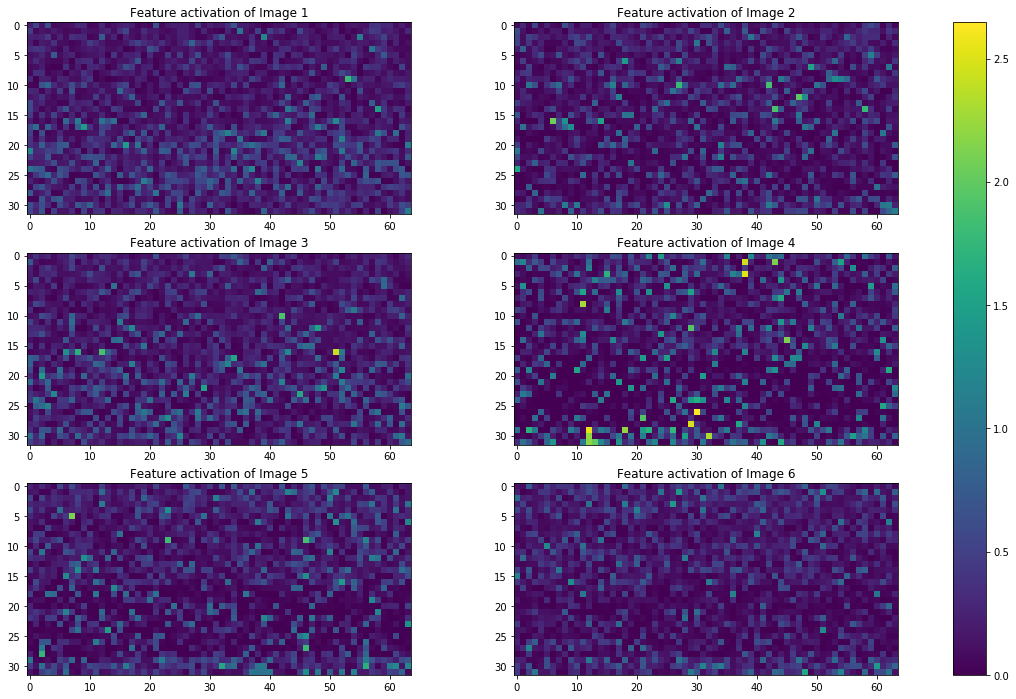

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20,12))
axes[0, 0].imshow(features[0].reshape(32, 64), vmin=vmin, vmax=vmax)
axes[0, 1].imshow(features[1].reshape(32, 64), vmin=vmin, vmax=vmax)
axes[1, 0].imshow(features[2].reshape(32, 64), vmin=vmin, vmax=vmax)
axes[1, 1].imshow(features[3].reshape(32, 64), vmin=vmin, vmax=vmax)
axes[2, 0].imshow(features[4].reshape(32, 64), vmin=vmin, vmax=vmax)
im = axes[2, 1].imshow(features[5].reshape(32, 64), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes.flat)  # https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar

axes[0, 0].set_title("Feature activation of Image 1")
axes[0, 1].set_title("Feature activation of Image 2")
axes[1, 0].set_title("Feature activation of Image 3")
axes[1, 1].set_title("Feature activation of Image 4")
axes[2, 0].set_title("Feature activation of Image 5")
axes[2, 1].set_title("Feature activation of Image 6")
plt.show()

Basically, it's difficult to spot difference here (except for the image 3 which look brighter).  However, we can computer the Jenson Shannon Divergence to have distance between those vectors

In [20]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

rel = [(0, 1), (0, 2), (1, 2), (0, 3), (4, 5)]
for image_a, image_b in rel:
    jsd = JSD(features[image_a].flatten(), features[image_b].flatten())
    print("Entropy between image {} and {} is {:.5f}".format(image_a, image_b, jsd))

Entropy between image 0 and 1 is 0.09621
Entropy between image 0 and 2 is 0.06595
Entropy between image 1 and 2 is 0.14012
Entropy between image 0 and 3 is 0.27313
Entropy between image 4 and 5 is 0.15157


As expected, the distance between the boat 1 and 2 is very small (at least smaller than the distance with the boat 3). The cat is far from boats (logically) and both cars are quite similar but not fully. Now we can have a look at Heatmap of the area which support the prediction

# Heatmap

## Principle

In classification, the "extractor" of the CNN (in this example the Inception V3) provides a 8 x 8 x 2048 tensor. This tensor is reduced to 1 x 1 x 2048 by using a Average Pooling Layer (or Max Pool Layer on some cases). This vector is then sent to a Fully connected layer for the classification. 1 simple level of Fully-Connected Layer is equivalent to one Linear Regression per class (without considering the activation). In Transfer-Learning, we basically retrain simply those Linear Models. This can be represented as follow :

<img src="classification.png">

The trick to have the heatmap is to reduce the 2048 feature to 1 by using the weight of the linear model (that means, this cannot be done with more complex clasifiers (multiple levels of FC layers for example). By conputing the "reglression over each of the 8 x 8 set of pixel, we can have an idea of what gives the more "force of the classification decision. This can be then represented as follow :

<img src="CAM.png">

Mathematically, this can be seens as a swap of "sum" :

- Classification

$$ PredictionValue_{class} = \sum_{i=1}^{2048} {\omega_{class, i}} * (\bar{M_{i}}) $$

with 

$$ \forall i \in [1, 2048] \Rightarrow \bar{M_i} = \frac{1}{64} \times  \sum_{j=1}^{8} (\sum_{k=1}^{8} {Feature_{j, k, i}}) $$

Instead in CAM we do :

$$ \forall j, k \in [1, 8] \Rightarrow  CAM_{class}[j, k] = \sum_{i=1}^{2048} \omega_{class, i} * Feature_{j, k, i
} $$

and we could go back to PredictionValue of this class by doing

$$ PredictionValue_{class} = \frac{1}{64} \times  \sum_{j=1}^{8} (\sum_{k=1}^{8} {CAM_{class}[j, k]}) $$

In this model we have a 8 x 8 feature size for a 299 x 299 image size. That means 1 feature "pixel" will contain the information of 37.5 pixels. Usually, to ease the visualization, we apply on this CAM matrix an interpolation. 

After the theory, let's do the practice

## Application

First let's extract the Feature tensor

In [21]:
out = base_model.get_layer("mixed10").output
inp = base_model.input

get_output = tf.keras.backend.function([inp], [out])

In [22]:
conv_outputs = get_output(X)[0]
conv_outputs.shape

(6, 8, 8, 2048)

As our model is trained, we can directly get the weight. In case of Transfer learning, the fit has to be done upfront

In [23]:
class_weights = base_model.layers[-1].get_weights()[0]
class_weights.shape

(2048, 1000)

Let's now compute the heatmap for 3 images and the top 3 of classes

In [24]:
idx = np.argsort(y_hat, axis=1)[:, -3:]
idx = idx[:, ::-1]

In [25]:
def get_heatmap(image_idx, label_idx):
#     cam = np.zeros(dtype = np.float32, shape = (8, 8))
#     for i, w in enumerate(class_weights[:, label_idx]):
#         cam += w * conv_outputs[image_idx, :, :, i]
    cam = (conv_outputs[image_idx] * class_weights[:, label_idx].reshape(1, 1, -1)).sum(axis=2)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (299, 299))
    heatmap = cv2.applyColorMap(np.uint8(255*(1-cam)), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.2)] = 0
    return heatmap

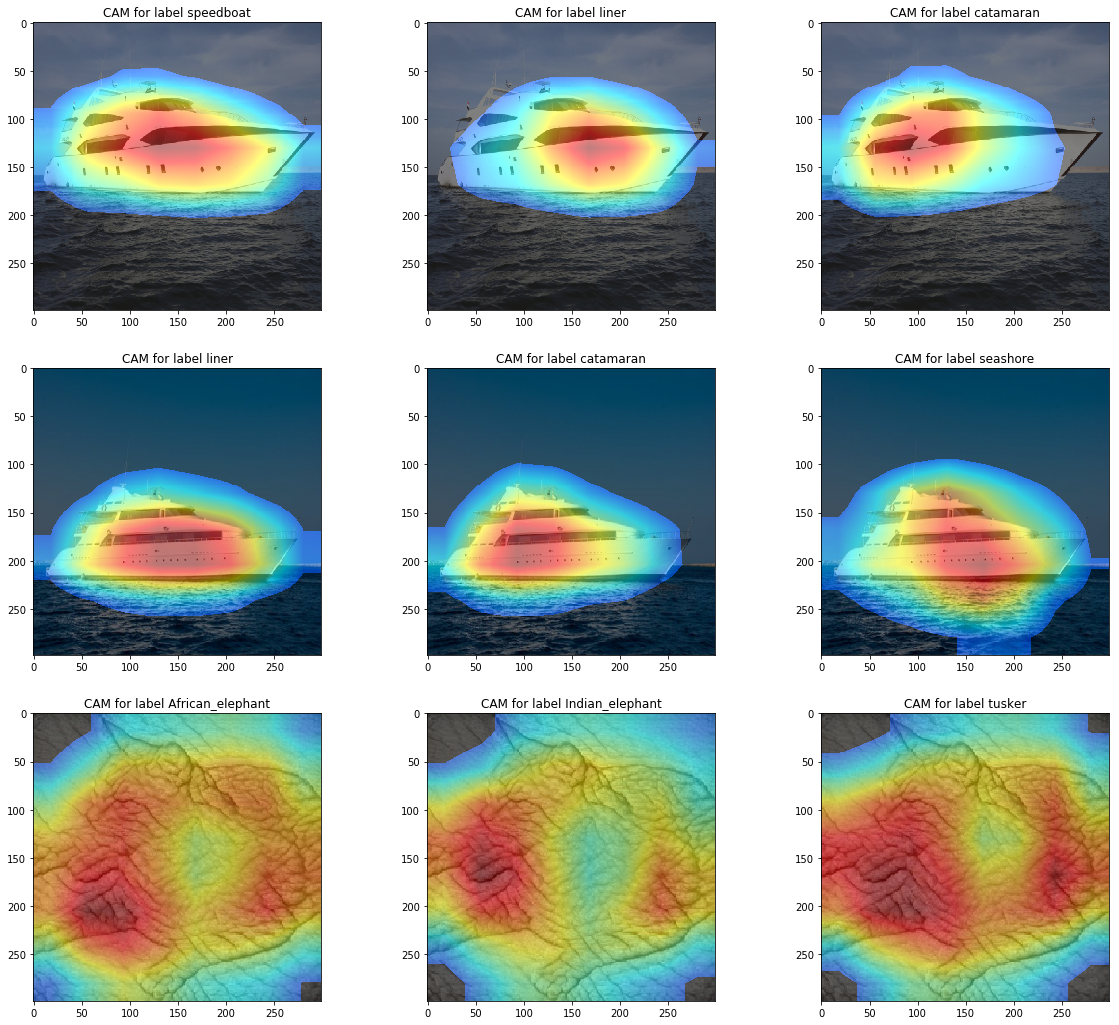

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(20,18))
for row, image_idx in enumerate([0, 1, 3]):
    for col, label_idx in enumerate(idx[image_idx]):
        heatmap = get_heatmap(image_idx, label_idx)
        img = 0.5 * heatmap + 0.5 * 255.0 * X[image_idx]
        pred_class = res[image_idx][col][1]
        axes[row, col].imshow(img/255.0)
        axes[row, col].set_title("CAM for label {}".format(pred_class))
plt.show()

And for the cat image, let's look at activation map for the classes of cat.  

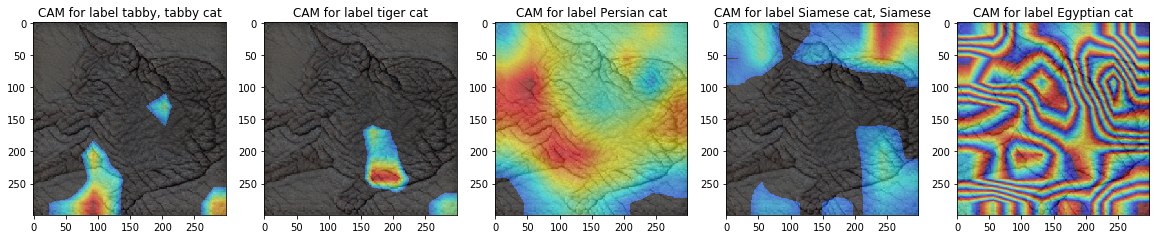

In [27]:
image_idx = 3
fig, axes = plt.subplots(1, 5, figsize=(20,20))
for col, label_idx in enumerate(range(281, 286)):
    heatmap = get_heatmap(image_idx, label_idx)
    img = 0.5 * heatmap + 0.5 * 255.0 * X[image_idx]
    pred_class = imagenet_sublabels[label_idx]
    axes[col].imshow(img/255.0)
    axes[col].set_title("CAM for label {}".format(pred_class))
plt.show()

The last image is strange but this is due to the cubic interpolation baceause pixels of same colors are not grouped

# Conclusion

In this Notebook, I wanted to apply the CAM on a pre-trained model and took the opportunity to play with the discovery with texture vs shape. This kind of visual is very interesting to check if the model trained overfits or not (just by looking if the model is really using the right area to make the prediction). .
However, the drawback of this method is that it cannot be used with more complex calssifier than liear because we need the importance of each feature in the prediction. A multi layer classifier cannot be used or also sklearn models. I only tried it by: 
- keeping the features
- reduce dimensions with PCA
- Train a Linear Model
- Invert the PCA with the weight of the Linear Model (to have weight is the initail space state)
- use those weight to build the activation map

This worked well too (and even better when you have a smaller dataset as you avoid overfitting).